In [1]:
import torch

from cci.utils import project_dir

device = torch.device("cpu")

model = torch.jit.load(
    project_dir() / "results/CNN_even_bigger_kernel_mlp_pr_fixed/171/0_model.pt",
    map_location=device,
)
model.eval()
model

RecursiveScriptModule(
  original_name=CNNModel
  (sequential): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv1d)
    (1): RecursiveScriptModule(original_name=BatchNorm1d)
    (2): RecursiveScriptModule(original_name=Dropout)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=Conv1d)
    (5): RecursiveScriptModule(original_name=BatchNorm1d)
    (6): RecursiveScriptModule(original_name=Dropout)
    (7): RecursiveScriptModule(original_name=ReLU)
    (8): RecursiveScriptModule(original_name=AdaptiveAvgPool1d)
    (9): RecursiveScriptModule(original_name=Flatten)
    (10): RecursiveScriptModule(original_name=Linear)
    (11): RecursiveScriptModule(original_name=Dropout)
    (12): RecursiveScriptModule(original_name=ReLU)
    (13): RecursiveScriptModule(original_name=Linear)
  )
)

In [61]:
import os
from pathlib import Path

import numpy as np
import scipy

file = "l_66"
# signal_path = Path(os.environ["OOCHA_DIR"]) / f"{file}.mat"
signal_path = Path("/home/halli/oohca") / f"{file}.mat"

signal = scipy.io.loadmat(signal_path, simplify_cells=True)["SIGNALS"][
    "ecg_diff"
].astype(np.float32)

In [62]:
window_size = 1500
overlap = 1


def infer_signal(model, signal) -> list:
    predictions = []
    for i in range(0, len(signal)):
        if i > window_size:
            window = torch.tensor(signal[i - window_size : i]).unsqueeze(0)
            prediction = torch.nn.functional.sigmoid(model(window))

            predictions.append(prediction.detach().item())
        else:
            # 0.5 before predictions start.
            predictions.append(0.5)
        if i % 100_000 == 0:
            print(i)
    return predictions


pr_pred = infer_signal(
    torch.jit.load(
        project_dir() / "results/CNN_even_bigger_kernel_mlp_pr_fixed/171/0_model.pt",
        map_location=device,
    ),
    signal,
)
pe_pred = infer_signal(
    torch.jit.load(
        project_dir() / "results/CNN_even_bigger_kernel_mlp_pe_fixed/141/0_model.pt",
        map_location=device,
    ),
    signal,
)
vft_pred = infer_signal(
    torch.jit.load(
        project_dir() / "results/CNN_even_bigger_kernel_mlp_vft_fixed/180/0_model.pt",
        map_location=device,
    ),
    signal,
)
as_pred = infer_signal(
    torch.jit.load(
        project_dir() / "results/CNN_even_bigger_kernel_mlp_as_fixed/64/0_model.pt",
        map_location=device,
    ),
    signal,
)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000


In [63]:
import polars as pl

df: pl.DataFrame = pl.DataFrame(
    {
        "pr": pr_pred,
        "pe": pe_pred,
        "vft": vft_pred,
        "as": as_pred,
    }
)

In [64]:
df.head()
df.write_csv(project_dir() / f"results/inference_{file}.csv")

In [28]:
import polars as pl

file = "a_19"
# file = "a_32"
# file = "a_150"
# file = "l_66"
df = pl.read_csv(project_dir() / f"results/inference_{file}.csv")

In [29]:
info = pl.read_csv(project_dir() / "data/full.csv").filter(pl.col("file") == file)

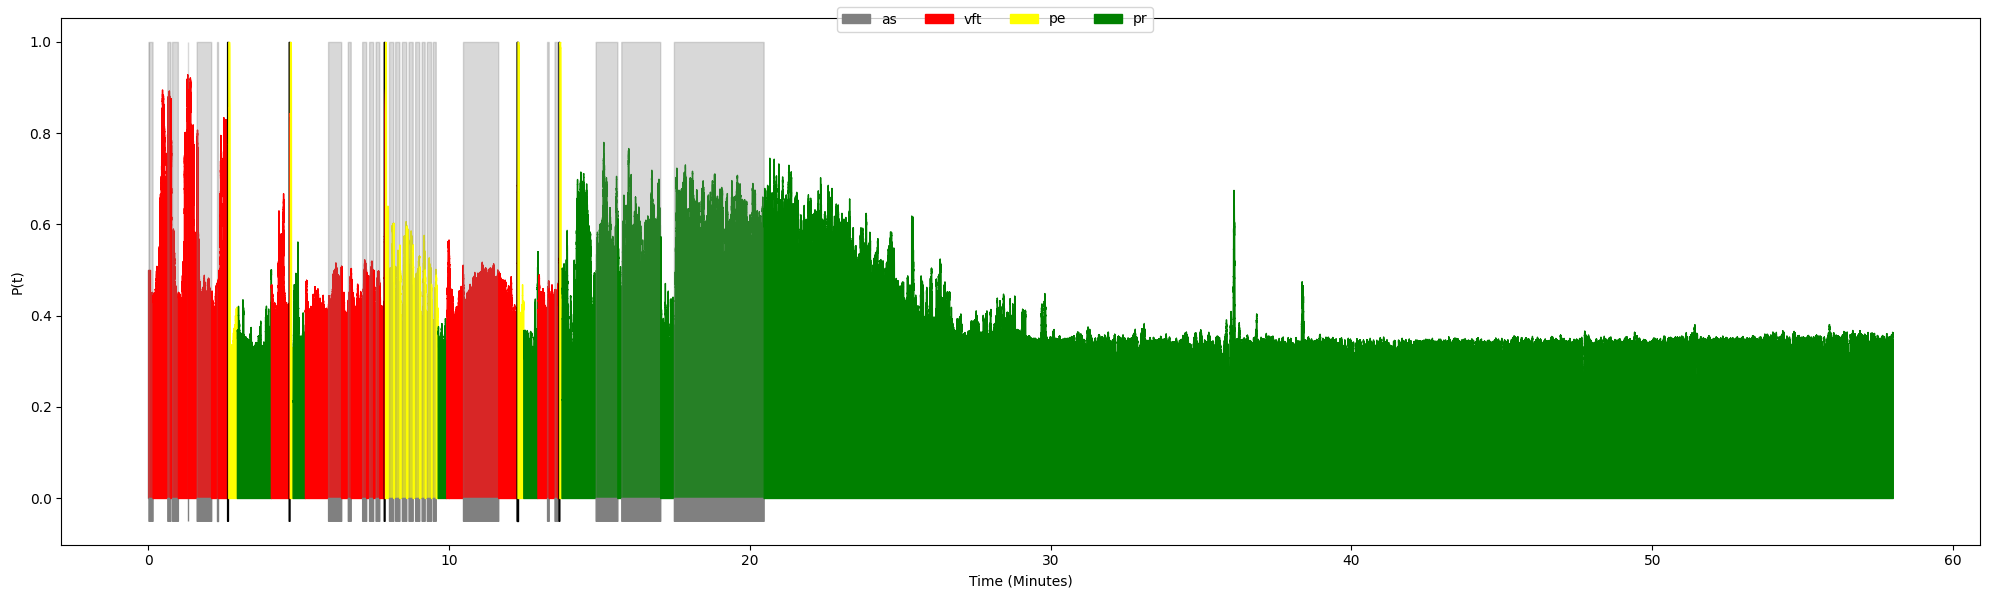

In [30]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(20, 6), sharex=True)
colors = {"vft": "red", "pe": "yellow", "pr": "green", "as": "gray"}
selected = "as"
# ax.fill_between([0, 1], [1, 0.5], color="skyblue")
filler = [[], []]
i = 0

for row in info.iter_rows(named=True):
    # print(row)
    epi = row["EPI"].lower()
    new_select = epi[-2:]
    # print(new_select)
    if new_select in ["pr", "pe", "vf", "vt", "as"]:
        if new_select in ["vf", "vt"]:
            selected = "vft"
        else:
            selected = new_select

    minutes = [x / 30_000 for x in range(row["Start"], row["Stop"])]

    ax.fill_between(
        minutes,
        df[selected].to_numpy()[row["Start"] : row["Stop"]],
        color=colors[selected],
        label=selected,
    )

    match epi[0]:
        case "c":
            ax.fill_between(
                minutes,
                1,
                color="gray",
                alpha=0.3,
            )
            ax.fill_between(
                minutes,
                -0.05,
                0,
                color="gray",
            )
        case "d":
            ax.fill_between(
                minutes,
                -0.05,
                1,
                color="black",
                alpha=1,
            )

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc="upper center", ncol=4)

ax.set_ylabel("P(t)")
ax.set_xlabel("Time (Minutes)")

plt.tight_layout()
plt.savefig(project_dir() / f"results/indicator_{file}.png")
plt.show()